In [ ]:
!pip install transformers[torch] datasets evaluate bleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5782 sha256=58fa541d25e938c5a68e28c51b252b81933ef4e935c4d13ba0b6d1b82afa777b
  Stored in directory: /root/.cache/pip/wheels/c6/d8/d1/009abe01b8b2c6a14c62d197b510b3cc1076014c22d712c5ce
Successfully built bleu


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Data Loading

In [ ]:
from datasets import load_dataset
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
books = load_dataset("cfilt/iitb-english-hindi")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

In [ ]:
books

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

In [ ]:
books['train'][0]['translation']

{'en': 'Give your application an accessibility workout',
 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}

In [ ]:
books["train"] = books["train"].select(range(127085))

In [ ]:
books = books['train'].train_test_split(test_size = 0.2)

In [ ]:
books

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 25417
    })
})

#Data Preprocessing

In [ ]:
from transformers import AutoTokenizer
model_type = 'Helsinki-NLP/opus-mt-en-hi'
tokenizer = AutoTokenizer.from_pretrained(model_type)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
tokenizer.vocab_size

61950

In [ ]:
source_lang = "en"
target_lang = "hi"
prefix = "translate English to Hindi: "

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_type)

# Model Evaluation

In [ ]:
import evaluate
metric = evaluate.load('bleu')

In [ ]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# Training

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_type)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="opus_hindi",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.401700,0.251225,0.881800,7.568400


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.401700,0.251225,0.881800,7.568400
2,0.278100,0.203870,0.891100,7.587400


TrainOutput(global_step=3178, training_loss=0.4067618560310878, metrics={'train_runtime': 3885.0728, 'train_samples_per_second': 52.338, 'train_steps_per_second': 0.818, 'total_flos': 2265011413843968.0, 'train_loss': 0.4067618560310878, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}


events.out.tfevents.1709916770.fa3351beef2c.197.0:   0%|          | 0.00/7.80k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/304M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Anmol1902/opus_hindi/commit/d9fda0e56b9af5d61f082da9c2c1300d0700df25', commit_message='End of training', commit_description='', oid='d9fda0e56b9af5d61f082da9c2c1300d0700df25', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
text = 'my name is anmol'
text

'my name is anmol'

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("opus_hindi")
inputs = tokenizer(text, return_tensors="pt").input_ids

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("opus_hindi")
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

In [ ]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'मेरा नाम mink है'

In [ ]:
# Extract the loss values
train_logs = trainer.state.log_history
train_losses = []
train_step = []

eval_losses = []
eval_step = []
for log in train_logs:
    if "loss" in log.keys():
        train_losses.append(log["loss"])
        train_step.append(log["step"])
    if "eval_loss" in log.keys():
        eval_losses.append(log["eval_loss"])
        eval_step.append(log["step"])
print(train_losses)
print(train_step)
print(eval_losses)
print(eval_step)

[0.7298, 0.4638, 0.4017, 0.3143, 0.2959, 0.2781]
[500, 1000, 1500, 2000, 2500, 3000]
[0.25122541189193726, 0.2038697898387909]
[1589, 3178]


In [ ]:
train_logs

[{'loss': 0.7298,
  'grad_norm': 3.135542631149292,
  'learning_rate': 1.6853366897419763e-05,
  'epoch': 0.31,
  'step': 500},
 {'loss': 0.4638,
  'grad_norm': 2.295417547225952,
  'learning_rate': 1.3706733794839521e-05,
  'epoch': 0.63,
  'step': 1000},
 {'loss': 0.4017,
  'grad_norm': 2.306408643722534,
  'learning_rate': 1.0560100692259283e-05,
  'epoch': 0.94,
  'step': 1500},
 {'eval_loss': 0.25122541189193726,
  'eval_bleu': 0.8818,
  'eval_gen_len': 7.5684,
  'eval_runtime': 1899.691,
  'eval_samples_per_second': 13.38,
  'eval_steps_per_second': 0.21,
  'epoch': 1.0,
  'step': 1589},
 {'loss': 0.3143,
  'grad_norm': 2.1247305870056152,
  'learning_rate': 7.413467589679045e-06,
  'epoch': 1.26,
  'step': 2000},
 {'loss': 0.2959,
  'grad_norm': 2.039937734603882,
  'learning_rate': 4.2668344870988045e-06,
  'epoch': 1.57,
  'step': 2500},
 {'loss': 0.2781,
  'grad_norm': 2.247509241104126,
  'learning_rate': 1.1202013845185652e-06,
  'epoch': 1.89,
  'step': 3000},
 {'eval_loss

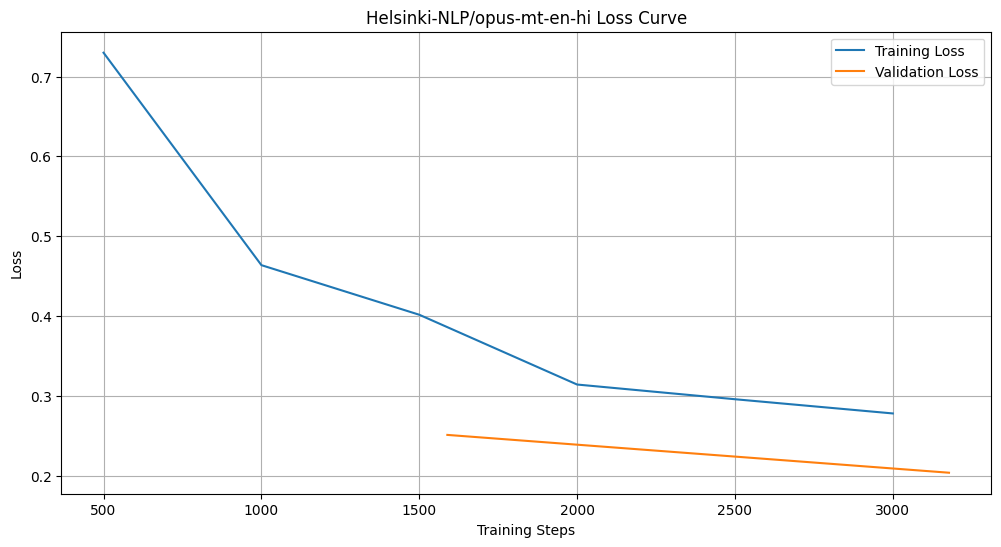

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for training losses
train_df = pd.DataFrame({'step': train_step, 'loss': train_losses})

# Create a DataFrame for evaluation losses
eval_df = pd.DataFrame({'step': eval_step, 'loss': eval_losses})

# Plot the training and evaluation losses
plt.figure(figsize=(12, 6))
sns.lineplot(x='step', y='loss', data=train_df, label='Training Loss')
sns.lineplot(x='step', y='loss', data=eval_df, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title(model_type+' Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
